# Pregunta 3: Convolutional Neural Network (CNN) en CIFAR.

En esta sección trabajaremos con un dataset bastante conocido y utilizado por la comunidad para experimentar con reconocimiento de objetos en imágenes: CIFAR10 [3]. Se trata de un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se atribuye a A. Krizhevsky, V. Nair y G. Hinton y viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba. El conjunto de pruebas fue obtenido seleccionando 1000 imágenes aleatorias de cada clase. Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento (batches). Las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: gatos, perros, ranas, caballos, pájaros, ciervos, aviones, automóviles, camiones y barcos. Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó ConvNets.

>a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$ , $Y_t$ , correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$,$Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.

Primero, se cargar las librerias necesarias para trabajar con redes neuronales, y otras para operaciones matemáticas y graficar datos.

In [1]:
import pickle
import numpy as np
import os
from scipy.misc import imread
import math
import matplotlib.pyplot as plt
import pydot_ng as pydot 
from IPython.display import Image, display, SVG
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model
from keras.models import load_model

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A continuación se preparan las variables que contienen la información de las imágenes, separándose en tres conjuntos: entrenamiento, validación y prueba. Antes de separar el conjunto de entrenamiento del de validación se desordenan los datos, pues estos podrían venir ordenados según sus etiquetas o algún otro orden preliminar. Al no hacer esto se escogerían datos de la misma clase para el conjunto de validación. Así el conjunto de entrenamiento tendrá 45.000 ejemplos, el de validación 5.000 y el de prueba 10.000 elementos. Estos ejemplos pueden pertenecer a una de las 10 etiquetas enumeradas del 0 al 9 en el siguiente orden: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.**

Para el entrenamiento de las redes se utilizará una GPU (Nvidia Geforce 840M) debido a los largos tiempo procesamiento y que estas unidades trabajan mejor realizando operaciones sobre matrices que las CPU. 

In [73]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        #print("f: ",f)
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
    
def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
#     print(len(Xtr))
#     print(len(Ytr))
    #add your Xval
    XY = list(zip(Xtr, Ytr))
    np.random.shuffle(XY)
    Xtr, Ytr = zip(*XY)
    msk = 45000
    Xva = np.array(Xtr[msk:])
    Yva = np.array(Ytr[msk:])   
    Xtr = np.array(Xtr[:msk])        
    Ytr = np.array(Ytr[:msk])
#     print(len(Xtr))
#     print(len(Ytr))
#     print(len(Xva))
#     print(len(Yva))
        
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xva, Yva, Xte, Yte

In [74]:
x_train, y_train, x_val, y_val, x_test, y_test = load_CIFAR10('.')
X = x_test
Y = y_test

In [ ]:
#seria bueno visualizar las imagenes~

>b) Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255. Es importante recordar que ahora se trabajará con la estructura original de los datos, por lo que es necesario recuperar la forma original de las imágenes del vector en el archivo en que vienen. Además, si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá hacer realizar la transposición correspondiente. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

Cada subconjunto formado en el paso anterior es normalizado, diviendo por 255.0 para llevar los datos a un rango \[0,1\].

In [75]:
print(x_train[0])
print(x_val[0])
print(x_test[0])

x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

print(x_train[0])
print(x_val[0])
print(x_test[0])

[100  99 101 ... 101  99  98]
[ 25  27  28 ... 196 162 138]
[158 159 165 ... 124 129 110]
[0.39215686 0.38823529 0.39607843 ... 0.39607843 0.38823529 0.38431373]
[0.09803922 0.10588235 0.10980392 ... 0.76862745 0.63529412 0.54117647]
[0.61960784 0.62352941 0.64705882 ... 0.48627451 0.50588235 0.43137255]


Las imagenes se transforman a sus dimensiones originales, es decir, cada imagen está representada por tres matrices cuadradasde 32x32. Cada una representa un canal R, G y B. Esta transformación es necesaria para utilizar capas convolucionales en la red neuronal.

Por otro lado, las etiquetas también deben ser etiquetadas como un *one hot vector*, dado que este es un problema de clasificación excluyente. Así, cada imagen tendrá un vector asociado que tendrá solo un 1 en la clase a la que corrresponde, y el resto serán 0.


In [76]:
x_train = x_train.reshape((x_train.shape[0],3,32,32))
print(x_train.shape)
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test = x_test.reshape((x_test.shape[0],3,32,32))
x_test = x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val = x_val.reshape((x_val.shape[0],3,32,32))
x_val = x_val.transpose([0, 2, 3, 1])

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(45000, 3, 32, 32)


In [77]:
print(x_val.shape)

(5000, 32, 32, 3)


>c) Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLu. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

Definición de arquitectura:
* C: Capa convolucional
* P: Capa de pooling
* F: Cada MLP como las de Feed Forward

Así, la arquitectura de la *Convolutional Neural Network* (CNN) red queda compuesta por las siguientes capas: Convolucional -> Pooling -> Convolucional -> Pooling -> Feed Forward -> Feed Forward. 

In [7]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

El input es recibido por la primera capa de convolución la cual tiene 64 filtros y cada uno es de tamaño 3x3. La función de esta capa es la extracción de características relevantes de cada imagen. Luego, se le aplica una función de activación ReLU a cada filtro. Después viene una capa de max pooling la cual realiza una reducción de dimensionalidad al seleccionar la característica más importante representada por el valor máximo que se encuentra en el espacio de 2x2 del filtro. Este proceso se repite para la siguiente capa de convolución (tercera capa) y pooling (cuarta capa).

Una vez que se han encontrado las características relevantes más importantes del input se introduce una capa altamente densa altamente conectada, como las que se ulitizan en las redes Feed Forward para considerar todas las permutaciones sobre estas características, y con esto, poder predecir la clase a la cual la imagen pertenece. Esta capa densa tiene 512 neuronas, a la cual se le aplica una función de activación ReLU.

Para finalizar la arquitectura de la red, se tiene una capa de 10 neuronas, donde cada una entrega la probabilidad de que una imagen input pertenezca a cierta clase gracias a la función de activación softmax. Esto asegura que la suma de las probabilidades sobre todas las clases sumen 1.




In [8]:
model.save('base_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('base_model.h5')

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


d) Entrene la CNN definida en c) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^4$ o inferior, pero durante las primeras epochs el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^3$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^5$. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 epochs.



In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

batch_size = 100#??
epochs = 25
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_sgd = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate])

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 49s 1ms/step - loss: 2.1281 - acc: 0.2302 - val_loss: 1.9557 - val_acc: 0.3100
Epoch 2/25
45000/45000 [==============================] - 44s 978us/step - loss: 1.8647 - acc: 0.3425 - val_loss: 1.7844 - val_acc: 0.3680
Epoch 3/25
45000/45000 [==============================] - 44s 986us/step - loss: 1.7089 - acc: 0.3982 - val_loss: 1.6188 - val_acc: 0.4254
Epoch 4/25
45000/45000 [==============================] - 47s 1ms/step - loss: 1.5715 - acc: 0.4458 - val_loss: 1.5313 - val_acc: 0.4550
Epoch 5/25
45000/45000 [==============================] - 53s 1ms/step - loss: 1.4694 - acc: 0.4835 - val_loss: 1.4457 - val_acc: 0.4840
Epoch 6/25
45000/45000 [==============================] - 53s 1ms/step - loss: 1.4194 - acc: 0.4996 - val_loss: 1.4158 - val_acc: 0.4948
Epoch 7/25
45000/45000 [==============================] - 52s 1ms/step - loss: 1.3840 - acc: 0.5105 - val_loss: 1.3796 - val_

In [10]:
model.save('base_sgd.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('base_sgd.h5')

In [11]:
def plot(hist):
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, loss, 'bo-', label = "Training set")
    ax.plot(epochs, val_loss, 'go-', label = "Test set")
    ax.set_title('Loss de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0,2)
    ax.legend(loc="upper right", fancybox= True)

    acc = hist['acc']
    val_acc = hist['val_acc']
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, np.subtract(1,acc), 'bo-', label = "Training set")
    ax.plot(epochs, np.subtract(1,val_acc), 'go-', label = "Test set")
    ax.set_title('Error de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    #ax.set_ylim(0,.8)
    ax.legend(loc="upper right", fancybox= True)
    plt.show()

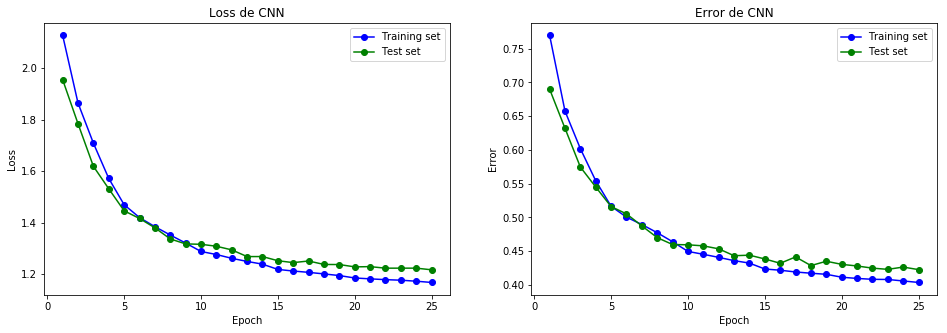

In [12]:
plot(model_sgd.history)

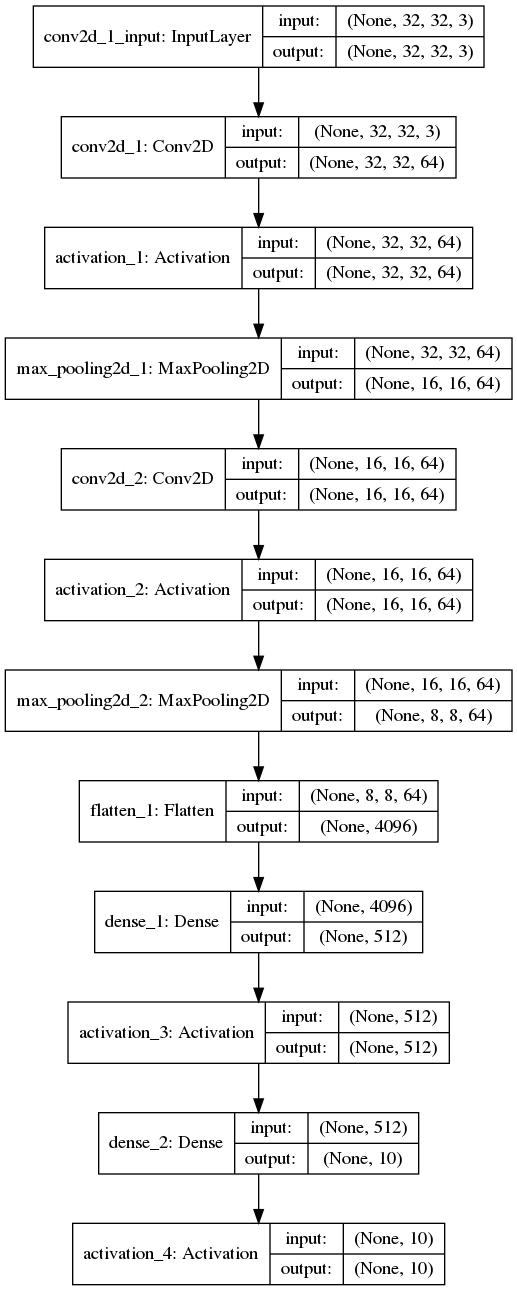

In [13]:
plot_model(model, to_file='model_sgd.png', show_shapes=True)
Image(filename='model_sgd.png')

Evaluand la red en el test set

In [14]:
score_Sgd = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 436us/step


In [15]:
print("Cross entropy:", score_Sgd[0])
print("Accuracy: ", score_Sgd[1])

Cross entropy: 1.2094698490142821
Accuracy:  0.5737


e) Entrene la CNN definida en c) utilizando RMSProp durante 25 epochs. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de epochs.

In [16]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
model_rmsprop = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 51s 1ms/step - loss: 5.1577 - acc: 0.3632 - val_loss: 1.3117 - val_acc: 0.5320
Epoch 2/25
45000/45000 [==============================] - 52s 1ms/step - loss: 1.1429 - acc: 0.5982 - val_loss: 1.0547 - val_acc: 0.6234
Epoch 3/25
45000/45000 [==============================] - 51s 1ms/step - loss: 0.9195 - acc: 0.6780 - val_loss: 0.9881 - val_acc: 0.6576
Epoch 4/25
45000/45000 [==============================] - 51s 1ms/step - loss: 0.7534 - acc: 0.7382 - val_loss: 0.8979 - val_acc: 0.6936
Epoch 5/25
45000/45000 [==============================] - 47s 1ms/step - loss: 0.6028 - acc: 0.7913 - val_loss: 0.9214 - val_acc: 0.7006
Epoch 6/25
45000/45000 [==============================] - 46s 1ms/step - loss: 0.4623 - acc: 0.8416 - val_loss: 0.9416 - val_acc: 0.7072
Epoch 7/25
45000/45000 [==============================] - 49s 1ms/step - loss: 0.3380 - acc: 0.8845 - val_loss: 1.0405 - val_acc:

In [17]:
model.save('base_msprop.h5')  # creates a HDF5 file 'my_model.h5'

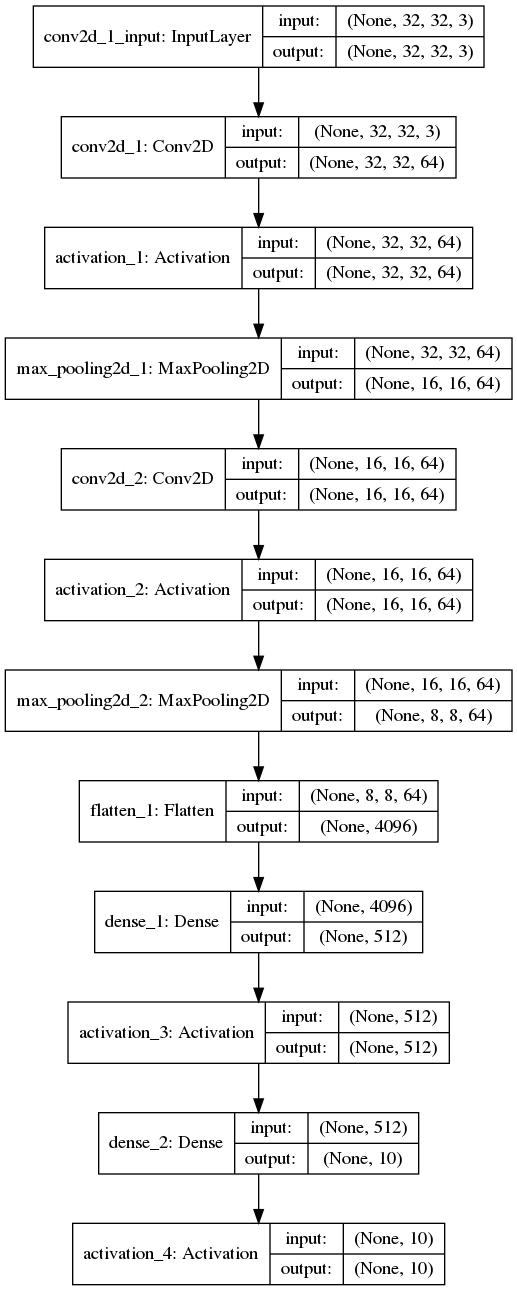

In [52]:
plot_model(model, to_file='model_msprop.png', show_shapes=True)
Image(filename='model_msprop.png')

In [19]:
score_msprop = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 377us/step


In [20]:
print("Cross entropy:", score_msprop[0])
print("Accuracy: ", score_msprop[1])

Cross entropy: 2.7516349842071532
Accuracy:  0.6801


f) Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 epochs.

aumnetar el campo de visión de una neurona

In [21]:
#Shallow network rmsprop
nc = 5
model_filtro_5 = Sequential()
model_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_filtro_5.add(Activation('relu'))
model_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_filtro_5.add(Flatten())
model_filtro_5.add(Dense(512))
model_filtro_5.add(Activation('relu'))
model_filtro_5.add(Dense(10))
model_filtro_5.add(Activation('softmax'))

In [22]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_filtro_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
model_fil_5 = model_filtro_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 65s 1ms/step - loss: 1.6037 - acc: 0.4438 - val_loss: 1.3292 - val_acc: 0.5292
Epoch 2/18
45000/45000 [==============================] - 64s 1ms/step - loss: 1.1592 - acc: 0.5945 - val_loss: 1.1318 - val_acc: 0.6144
Epoch 3/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.9571 - acc: 0.6657 - val_loss: 1.1435 - val_acc: 0.6140
Epoch 4/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.7887 - acc: 0.7276 - val_loss: 1.0027 - val_acc: 0.6584
Epoch 5/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.6371 - acc: 0.7816 - val_loss: 1.0808 - val_acc: 0.6482
Epoch 6/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.4968 - acc: 0.8291 - val_loss: 1.1276 - val_acc: 0.6646
Epoch 7/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.3726 - acc: 0.8744 - val_loss: 1.1431 - val_acc:

In [23]:
model_filtro_5.save('shallow_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

In [24]:
score_shallow_net_5_msprop = model_filtro_5.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 360us/step


In [25]:
print("Cross entropy:", score_shallow_net_5_msprop[0])
print("Accuracy: ", score_shallow_net_5_msprop[1])

Cross entropy: 2.4099161121368406
Accuracy:  0.6615


In [26]:
#Shallow network rmsprop
nc = 3
model_shadow_filtro_3 = Sequential()
model_shadow_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_shadow_filtro_3.add(Activation('relu'))
model_shadow_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_shadow_filtro_3.add(Flatten())
model_shadow_filtro_3.add(Dense(512))
model_shadow_filtro_3.add(Activation('relu'))
model_shadow_filtro_3.add(Dense(10))
model_shadow_filtro_3.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_shadow_filtro_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
shallow_net_3_msprop = model_shadow_filtro_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_shadow_filtro_3.save('shallow_net_3_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'
model_shadow_filtro_3.save_weights('shallow_net_3_rmsprop_weights.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 64s 1ms/step - loss: 1.5884 - acc: 0.4609 - val_loss: 1.2436 - val_acc: 0.5566
Epoch 2/18
45000/45000 [==============================] - 64s 1ms/step - loss: 1.1494 - acc: 0.5964 - val_loss: 1.1268 - val_acc: 0.6008
Epoch 3/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.9695 - acc: 0.6629 - val_loss: 1.0215 - val_acc: 0.6472
Epoch 4/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.8191 - acc: 0.7156 - val_loss: 0.9771 - val_acc: 0.6646
Epoch 5/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.6823 - acc: 0.7640 - val_loss: 0.9921 - val_acc: 0.6678
Epoch 6/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.5555 - acc: 0.8088 - val_loss: 1.0284 - val_acc: 0.6684
Epoch 7/18
45000/45000 [==============================] - 64s 1ms/step - loss: 0.4366 - acc: 0.8548 - val_loss: 1.0839 - val_acc:

In [27]:
score_shallow_net_3_msprop = model_shadow_filtro_3.evaluate(x_test, y_test)
print("Cross entropy:", score_shallow_net_3_msprop[0])
print("Accuracy: ", score_shallow_net_3_msprop[1])

10000/10000 [==============================] - 4s 350us/step
Cross entropy: 2.1375541523933412
Accuracy:  0.6693


In [28]:
#Deep network rmsprop
nc = 5
model_deep_filtro_5 = Sequential()
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Flatten())
model_deep_filtro_5.add(Dense(512))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(Dense(10))
model_deep_filtro_5.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_deep_filtro_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
score_deep_net_5_msprop = model_deep_filtro_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_deep_filtro_5.save('deep_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 53s 1ms/step - loss: 1.7482 - acc: 0.3719 - val_loss: 1.2894 - val_acc: 0.5438
Epoch 2/18
45000/45000 [==============================] - 52s 1ms/step - loss: 1.2119 - acc: 0.5730 - val_loss: 1.0894 - val_acc: 0.6146
Epoch 3/18
45000/45000 [==============================] - 52s 1ms/step - loss: 0.9778 - acc: 0.6582 - val_loss: 0.9722 - val_acc: 0.6682
Epoch 4/18
45000/45000 [==============================] - 52s 1ms/step - loss: 0.8172 - acc: 0.7168 - val_loss: 0.9797 - val_acc: 0.6604
Epoch 5/18
45000/45000 [==============================] - 52s 1ms/step - loss: 0.6888 - acc: 0.7590 - val_loss: 0.8438 - val_acc: 0.7142
Epoch 6/18
45000/45000 [==============================] - 52s 1ms/step - loss: 0.5784 - acc: 0.7979 - val_loss: 0.8364 - val_acc: 0.7258
Epoch 7/18
45000/45000 [==============================] - 52s 1ms/step - loss: 0.4717 - acc: 0.8350 - val_loss: 0.9911 - val_acc:

In [29]:
scoree_deep_net_5_msprop = model_deep_filtro_5.evaluate(x_test, y_test)
print("Cross entropy:", scoree_deep_net_5_msprop[0])
print("Accuracy: ", scoree_deep_net_5_msprop[1])

10000/10000 [==============================] - 5s 486us/step
Cross entropy: 2.0162562233924866
Accuracy:  0.7154


In [30]:
#Deep network rmsprop
nc = 3
model_deep_filtro_3 = Sequential()
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Flatten())
model_deep_filtro_3.add(Dense(512))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(Dense(10))
model_deep_filtro_3.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_deep_filtro_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
deep_net_3_msprop = model_deep_filtro_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_deep_filtro_3.save('deep_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 42s 936us/step - loss: 1.6510 - acc: 0.4064 - val_loss: 1.2737 - val_acc: 0.5446
Epoch 2/18
45000/45000 [==============================] - 42s 930us/step - loss: 1.1779 - acc: 0.5856 - val_loss: 1.0728 - val_acc: 0.6190
Epoch 3/18
45000/45000 [==============================] - 42s 924us/step - loss: 0.9676 - acc: 0.6604 - val_loss: 0.9388 - val_acc: 0.6728
Epoch 4/18
45000/45000 [==============================] - 42s 928us/step - loss: 0.8246 - acc: 0.7127 - val_loss: 0.8131 - val_acc: 0.7150
Epoch 5/18
45000/45000 [==============================] - 42s 928us/step - loss: 0.7126 - acc: 0.7512 - val_loss: 0.8376 - val_acc: 0.7104
Epoch 6/18
45000/45000 [==============================] - 42s 927us/step - loss: 0.6144 - acc: 0.7842 - val_loss: 0.8099 - val_acc: 0.7338
Epoch 7/18
45000/45000 [==============================] - 42s 924us/step - loss: 0.5233 - acc: 0.8181 - val_loss: 0.8

In [31]:
score_deep_net_3_msprop = model_deep_filtro_3.evaluate(x_test, y_test)
print("Cross entropy:", score_deep_net_3_msprop[0])
print("Accuracy: ", score_deep_net_3_msprop[1])

10000/10000 [==============================] - 4s 389us/step
Cross entropy: 1.7165305886268616
Accuracy:  0.7389


	 Shadow network 3


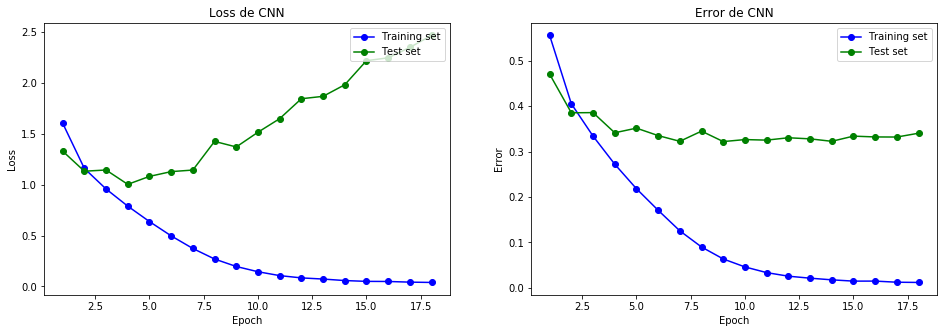

	 Shadow network 5


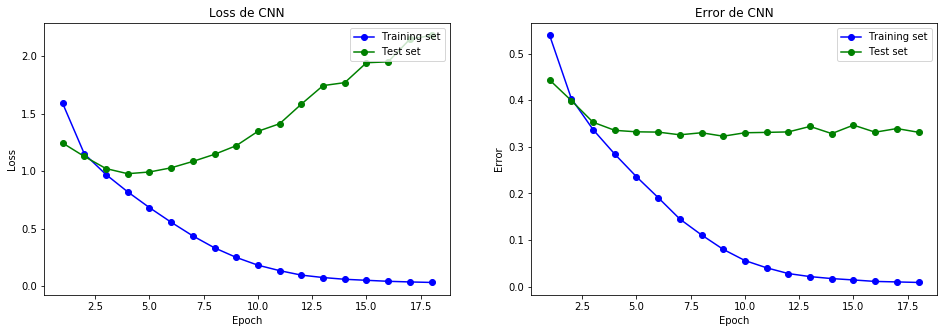

	 Deep network 3


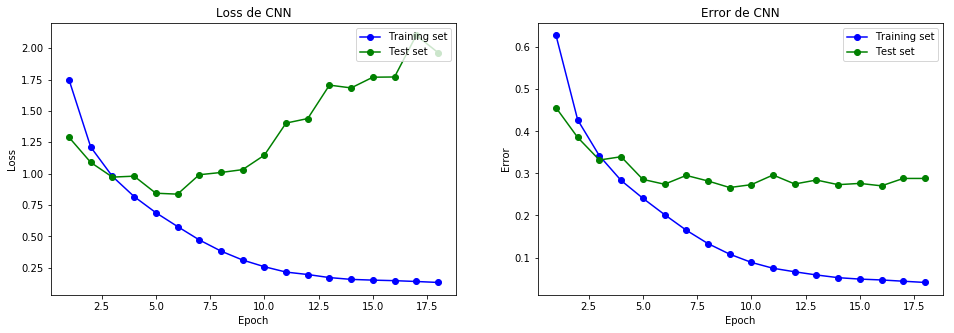

	 Deep network 5


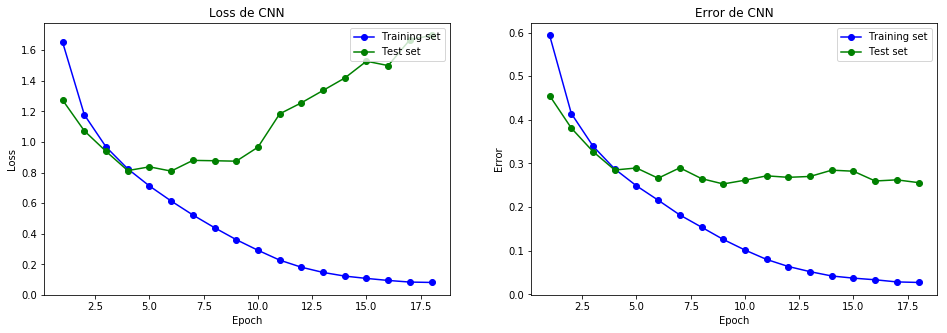

In [32]:
print("\t Shadow network 3")
plot(model_fil_5.history)
#shallow_net_3_msprop = load_model('shallow_net_3_rmsprop_weights.h5')
print("\t Shadow network 5")
plot(shallow_net_3_msprop.history)
print("\t Deep network 3")
plot(score_deep_net_5_msprop.history)
print("\t Deep network 5")
plot(deep_net_3_msprop.history)

In [57]:
#justo antes de la g
def plot2(hist1, title1, hist2, title2):
    loss1 = hist1['loss']
    val_loss1 = hist1['val_loss']
    loss2 = hist2['loss']
    val_loss2 = hist2['val_loss']
    epochs = range(1, len(loss1) + 1)
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, loss1, 'bo-', label = "Training set " + title1)
    ax.plot(epochs, loss2, 'b^-', label = "Training set " + title2)
    ax.plot(epochs, val_loss1, 'go-', label = "Test set " + title1)
    ax.plot(epochs, val_loss2, 'g^-', label = "Test set " + title2)
    ax.set_title('Loss de CNN ' + title1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0,2)
    ax.legend(loc="upper right", fancybox= True)

    acc1 = hist1['acc']
    val_acc1 = hist1['val_acc']
    acc2 = hist2['acc']
    val_acc2 = hist2['val_acc']
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, np.subtract(1,acc1), 'bo-', label = "Training set " + title1)
    ax.plot(epochs, np.subtract(1,acc2), 'b^-', label = "Training set " + title2)
    ax.plot(epochs, np.subtract(1,val_acc1), 'go-', label = "Test set " + title1)
    ax.plot(epochs, np.subtract(1,val_acc2), 'g^-', label = "Test set " + title2)
    ax.set_title('Error de CNN ' + title1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    #ax.set_ylim(0,.8)
    ax.legend(loc="upper right", fancybox= True)
    plt.show()

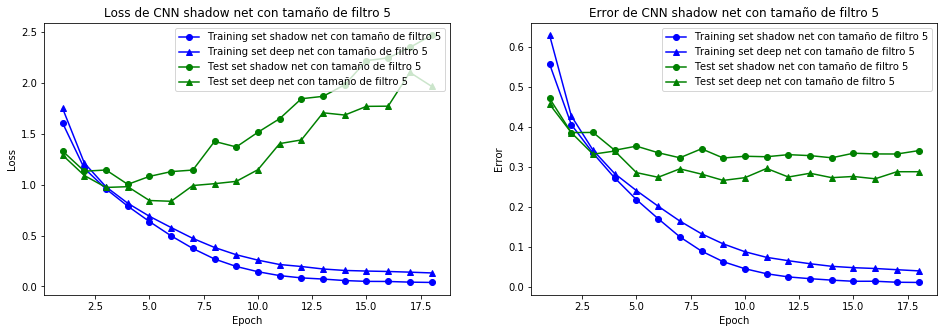

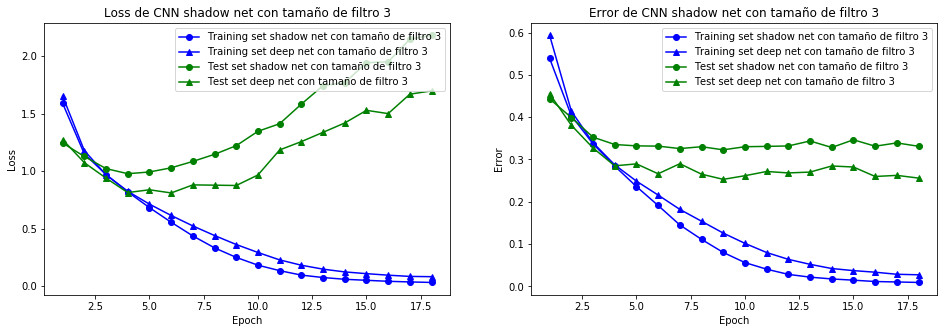

In [58]:
plot2(model_fil_5.history, "shadow net con tamaño de filtro 5", score_deep_net_5_msprop.history, "deep net con tamaño de filtro 5")
plot2(shallow_net_3_msprop.history, "shadow net con tamaño de filtro 3", deep_net_3_msprop.history, "deep net con tamaño de filtro 3")

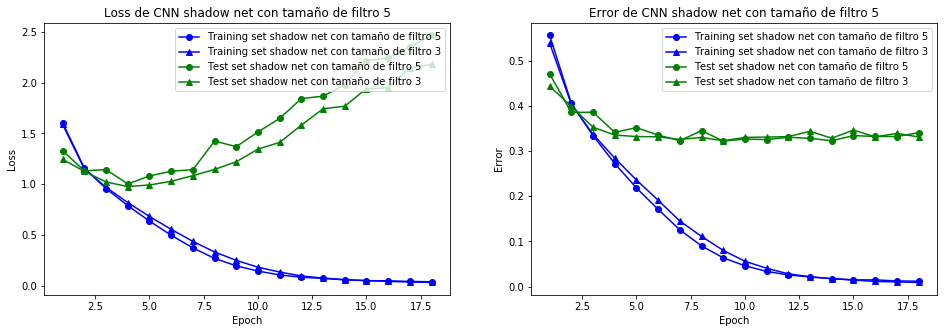

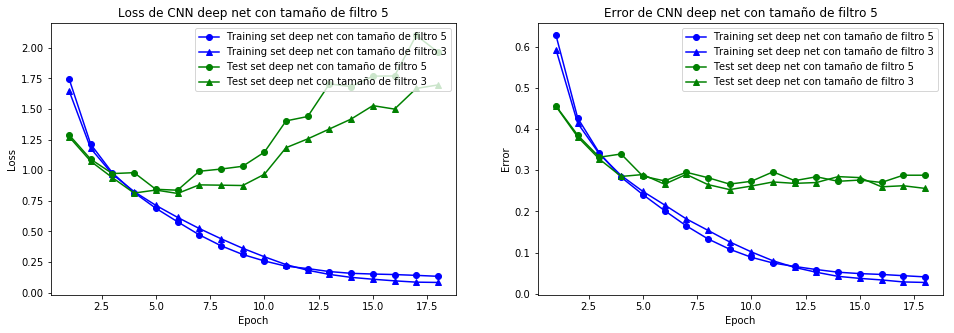

In [59]:
plot2(model_fil_5.history, "shadow net con tamaño de filtro 5", shallow_net_3_msprop.history, "shadow net con tamaño de filtro 3")
plot2(score_deep_net_5_msprop.history, "deep net con tamaño de filtro 5", deep_net_3_msprop.history, "deep net con tamaño de filtro 3")

g) Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de pooling puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para las primeras 2 capas convolucionales y 128 para las últimas dos. Reflexione sobre qué le parece más sensato: ¿mantener el tamaño de los filtros usados anteriormente? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera? Hint: con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráficque los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [33]:
model_2c = Sequential()
#C x C x P
model_2c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c.add(Activation('relu'))
model_2c.add(Conv2D(64, (3, 3), padding='same'))
model_2c.add(Activation('relu'))
model_2c.add(MaxPooling2D(pool_size=(2, 2)))
model_2c.add(Dropout(0.25))
#C x C x P
model_2c.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c.add(Activation('relu'))
model_2c.add(Conv2D(128, (3, 3), padding='same'))
model_2c.add(Activation('relu'))
model_2c.add(MaxPooling2D(pool_size=(2, 2)))
model_2c.add(Dropout(0.25))
#F x F
model_2c.add(Flatten())
model_2c.add(Dense(512, activation='relu'))
model_2c.add(Dropout(0.25))
model_2c.add(Dense(10, activation='softmax'))
model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       73856     
__________

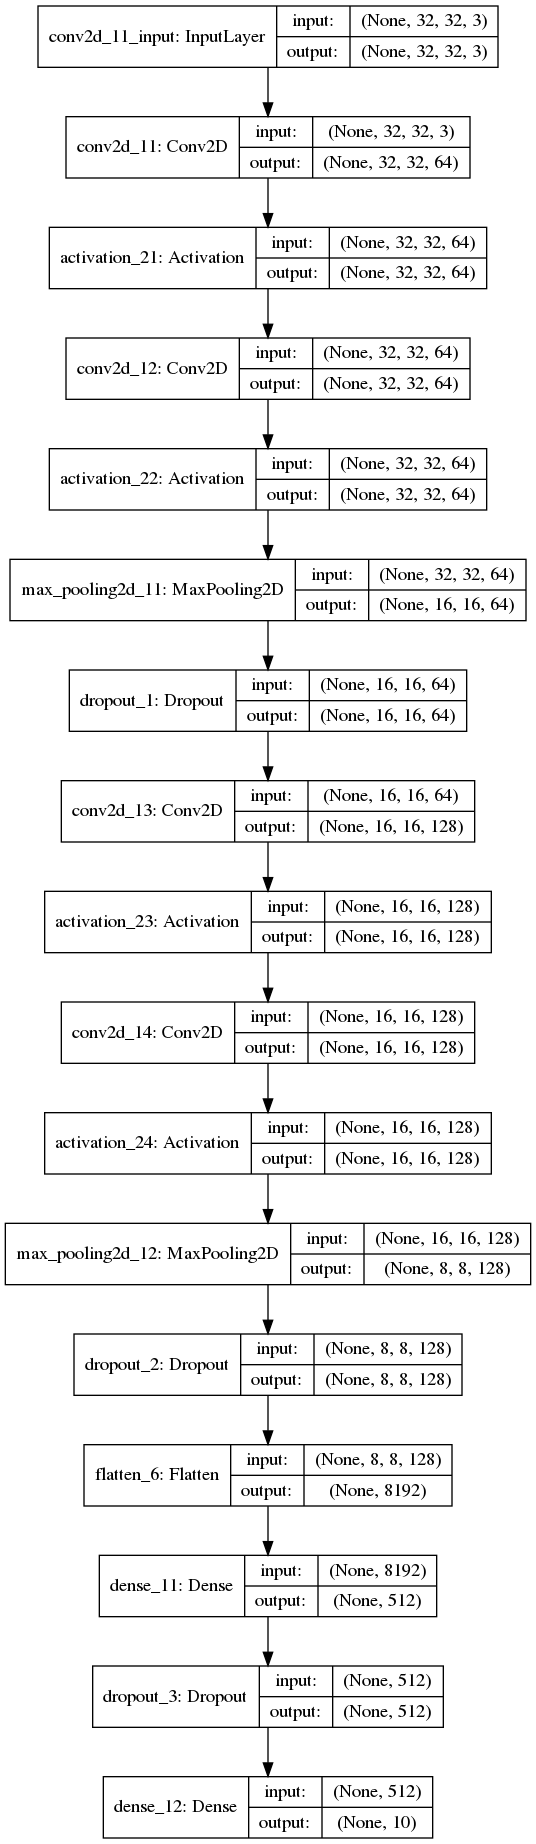

In [53]:
plot_model(model_2c, to_file='model_2c_rmsprop.png', show_shapes=True)
Image(filename='model_2c_rmsprop.png')

In [35]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_rmsprop = model_2c.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c.save('model_2c_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 137s 3ms/step - loss: 1.6950 - acc: 0.3913 - val_loss: 1.2039 - val_acc: 0.5606
Epoch 2/25
45000/45000 [==============================] - 136s 3ms/step - loss: 1.1108 - acc: 0.6122 - val_loss: 0.8706 - val_acc: 0.6950
Epoch 3/25
45000/45000 [==============================] - 136s 3ms/step - loss: 0.8797 - acc: 0.6949 - val_loss: 0.7729 - val_acc: 0.7312
Epoch 4/25
45000/45000 [==============================] - 136s 3ms/step - loss: 0.7444 - acc: 0.7428 - val_loss: 0.6998 - val_acc: 0.7606
Epoch 5/25
45000/45000 [==============================] - 136s 3ms/step - loss: 0.6402 - acc: 0.7776 - val_loss: 0.8008 - val_acc: 0.7448
Epoch 6/25
45000/45000 [==============================] - 136s 3ms/step - loss: 0.5658 - acc: 0.8072 - val_loss: 0.6451 - val_acc: 0.7854
Epoch 7/25
45000/45000 [==============================] - 136s 3ms/step - loss: 0.5160 - acc: 0.8251 - val_loss: 0.7437 - v

In [36]:
score_model_2c_msprop = model_2c.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_msprop[0])
print("Accuracy: ", score_model_2c_msprop[1])

10000/10000 [==============================] - 10s 979us/step
Cross entropy: 0.8844824047088623
Accuracy:  0.7941


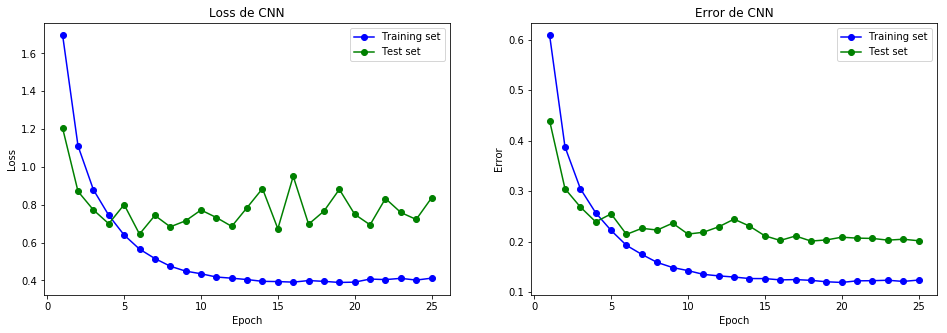

In [37]:
plot(model_2c_rmsprop.history)

Se prueba en el primer par de capas con 128 filtros para las dos primeras capas convolucionales y 64 para otras dos capas cnvolucionales

In [38]:
model_2c_128_64 = Sequential()
#C x C x P
model_2c_128_64.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(Conv2D(128, (3, 3), padding='same'))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64.add(Dropout(0.25))
#C x C x P
model_2c_128_64.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(Conv2D(64, (3, 3), padding='same'))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64.add(Dropout(0.25))
#F x F
model_2c_128_64.add(Flatten())
model_2c_128_64.add(Dense(512, activation='relu'))
model_2c_128_64.add(Dropout(0.25))
model_2c_128_64.add(Dense(10, activation='softmax'))
model_2c_128_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        73792     
__________

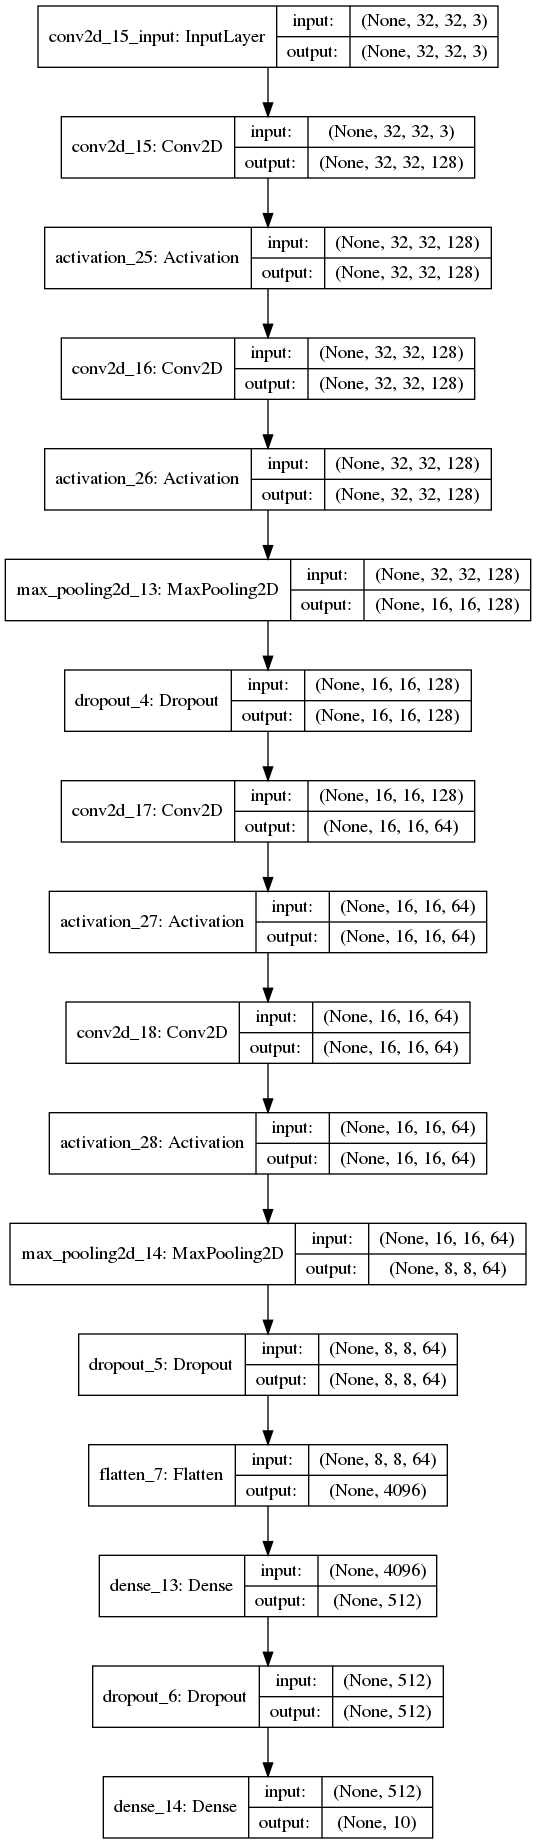

In [54]:
plot_model(model_2c_128_64, to_file='model_2c_128_64_rmsprop.png', show_shapes=True)
Image(filename='model_2c_128_64_rmsprop.png')

In [40]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c_128_64.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_128_64_rmsprop = model_2c_128_64.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c_128_64.save('model_2c_128_164_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 198s 4ms/step - loss: 1.7240 - acc: 0.3815 - val_loss: 1.2257 - val_acc: 0.5576
Epoch 2/25
45000/45000 [==============================] - 196s 4ms/step - loss: 1.1804 - acc: 0.5842 - val_loss: 1.0780 - val_acc: 0.6176
Epoch 3/25
45000/45000 [==============================] - 195s 4ms/step - loss: 0.9410 - acc: 0.6740 - val_loss: 0.7979 - val_acc: 0.7176
Epoch 4/25
45000/45000 [==============================] - 196s 4ms/step - loss: 0.7927 - acc: 0.7257 - val_loss: 0.7927 - val_acc: 0.7202
Epoch 5/25
45000/45000 [==============================] - 196s 4ms/step - loss: 0.6935 - acc: 0.7606 - val_loss: 0.7603 - val_acc: 0.7478
Epoch 6/25
45000/45000 [==============================] - 196s 4ms/step - loss: 0.6149 - acc: 0.7899 - val_loss: 0.6512 - val_acc: 0.7742
Epoch 7/25
45000/45000 [==============================] - 196s 4ms/step - loss: 0.5540 - acc: 0.8099 - val_loss: 0.6690 - v

In [41]:
score_model_2c_128_64_msprop = model_2c_128_64.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_128_64_msprop[0])
print("Accuracy: ", score_model_2c_128_64_msprop[1])

10000/10000 [==============================] - 15s 1ms/step
Cross entropy: 0.9254186977863311
Accuracy:  0.7642


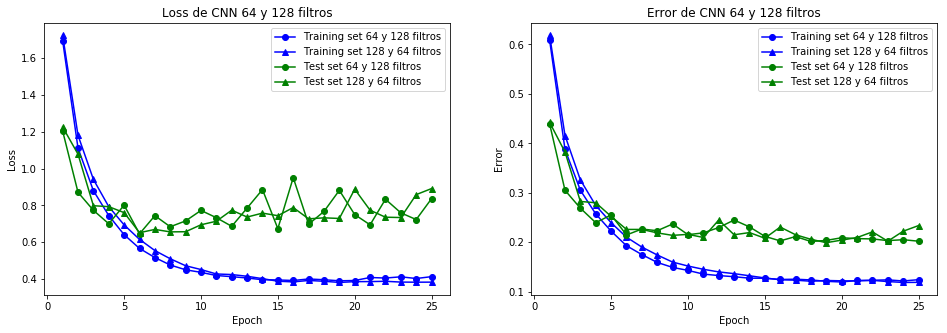

In [61]:
plot2(model_2c_rmsprop.history, "64 y 128 filtros", model_2c_128_64_rmsprop.history, "128 y 64 filtros")

modificando la cantidad de filtros y sus tamaños

In [42]:
model_2c_128_64_3_5 = Sequential()
#C x C x P
model_2c_128_64_3_5.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64_3_5.add(Activation('relu'))
model_2c_128_64_3_5.add(Conv2D(128, (3, 3), padding='same'))
model_2c_128_64_3_5.add(Activation('relu'))
model_2c_128_64_3_5.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64_3_5.add(Dropout(0.25))
#C x C x P
model_2c_128_64_3_5.add(Conv2D(64, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64_3_5.add(Activation('relu'))
model_2c_128_64_3_5.add(Conv2D(64, (5, 5), padding='same'))
model_2c_128_64_3_5.add(Activation('relu'))
model_2c_128_64_3_5.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64_3_5.add(Dropout(0.25))
#F x F
model_2c_128_64_3_5.add(Flatten())
model_2c_128_64_3_5.add(Dense(512, activation='relu'))
model_2c_128_64_3_5.add(Dropout(0.25))
model_2c_128_64_3_5.add(Dense(10, activation='softmax'))
model_2c_128_64_3_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        204864    
__________

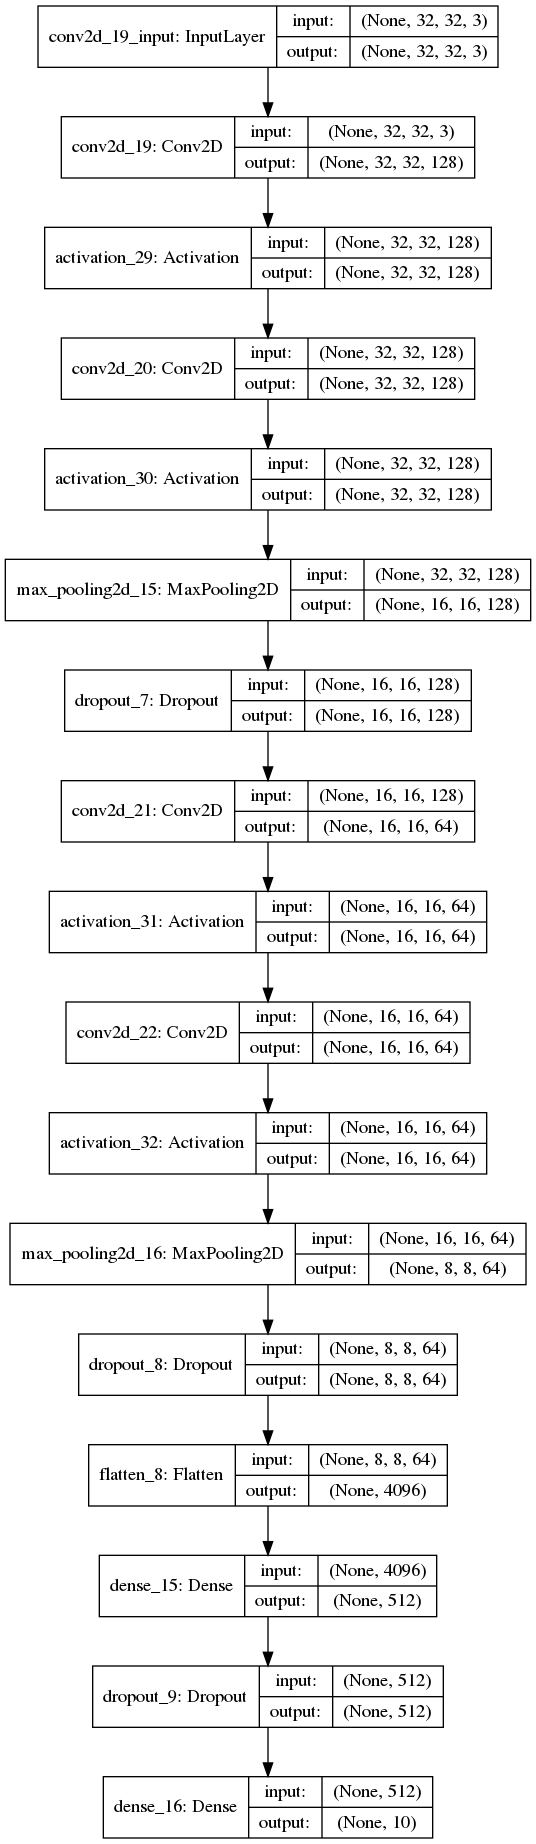

In [55]:
plot_model(model_2c_128_64_3_5, to_file='model_2c_128_64_3_5rmsprop.png', show_shapes=True)
Image(filename='model_2c_128_64_3_5rmsprop.png')

In [44]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c_128_64_3_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_128_64_3_5_rmsprop = model_2c_128_64_3_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c_128_64_3_5.save('model_2c_128_164_3_5_rmsprop.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 217s 5ms/step - loss: 1.7877 - acc: 0.3678 - val_loss: 1.5131 - val_acc: 0.4762
Epoch 2/25
45000/45000 [==============================] - 216s 5ms/step - loss: 1.1483 - acc: 0.5962 - val_loss: 0.9032 - val_acc: 0.6750
Epoch 3/25
45000/45000 [==============================] - 216s 5ms/step - loss: 0.9076 - acc: 0.6876 - val_loss: 0.8490 - val_acc: 0.6980
Epoch 4/25
45000/45000 [==============================] - 216s 5ms/step - loss: 0.7767 - acc: 0.7316 - val_loss: 0.7228 - val_acc: 0.7492
Epoch 5/25
45000/45000 [==============================] - 216s 5ms/step - loss: 0.6855 - acc: 0.7645 - val_loss: 0.7031 - val_acc: 0.7644
Epoch 6/25
45000/45000 [==============================] - 216s 5ms/step - loss: 0.6120 - acc: 0.7897 - val_loss: 0.7285 - val_acc: 0.7646
Epoch 7/25
45000/45000 [==============================] - 216s 5ms/step - loss: 0.5628 - acc: 0.8081 - val_loss: 0.6931 - v

In [46]:
score_model_2c_128_64_3_5_rmsprop = model_2c_128_64_3_5.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_128_64_3_5_rmsprop[0])
print("Accuracy: ", score_model_2c_128_64_3_5_rmsprop[1])

10000/10000 [==============================] - 18s 2ms/step
Cross entropy: 0.87342160820961
Accuracy:  0.7785


In [47]:
model_2c_128_64_5_3 = Sequential()
#C x C x P
model_2c_128_64_5_3.add(Conv2D(128, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64_5_3.add(Activation('relu'))
model_2c_128_64_5_3.add(Conv2D(128, (5, 5), padding='same'))
model_2c_128_64_5_3.add(Activation('relu'))
model_2c_128_64_5_3.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64_5_3.add(Dropout(0.25))
#C x C x P
model_2c_128_64_5_3.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64_5_3.add(Activation('relu'))
model_2c_128_64_5_3.add(Conv2D(64, (3, 3), padding='same'))
model_2c_128_64_5_3.add(Activation('relu'))
model_2c_128_64_5_3.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64_5_3.add(Dropout(0.25))
#F x F
model_2c_128_64_5_3.add(Flatten())
model_2c_128_64_5_3.add(Dense(512, activation='relu'))
model_2c_128_64_5_3.add(Dropout(0.25))
model_2c_128_64_5_3.add(Dense(10, activation='softmax'))
model_2c_128_64_5_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       409728    
_________________________________________________________________
activation_34 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        73792     
__________

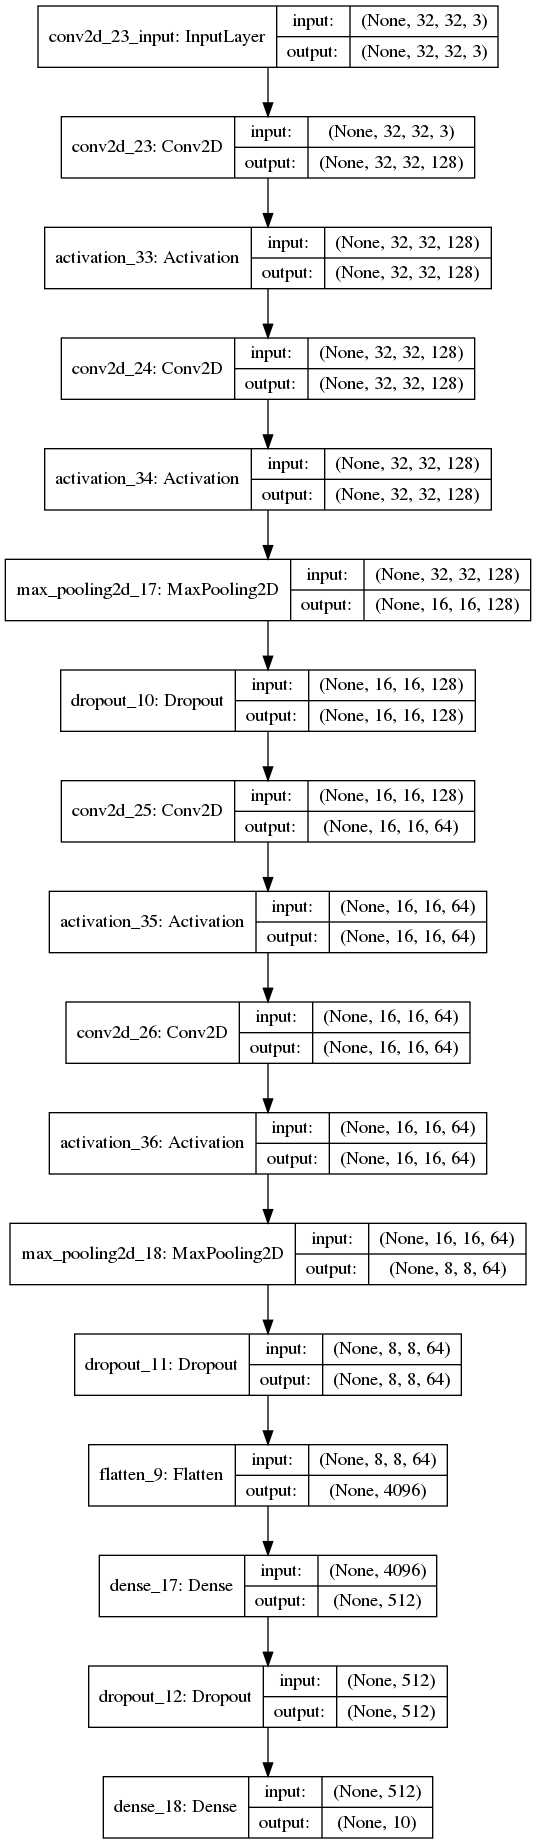

In [56]:
plot_model(model_2c_128_64_5_3, to_file='model_2c_128_64_5_3_rmsprop.png', show_shapes=True)
Image(filename='model_2c_128_64_5_3_rmsprop.png')

In [49]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c_128_64_5_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_128_64_5_3_rmsprop = model_2c_128_64_5_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c_128_64_5_3.save('model_2c_128_164_3_5_rmsprop.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 266s 6ms/step - loss: 1.8812 - acc: 0.3335 - val_loss: 1.3669 - val_acc: 0.5120
Epoch 2/25
45000/45000 [==============================] - 260s 6ms/step - loss: 1.2986 - acc: 0.5427 - val_loss: 1.1414 - val_acc: 0.6004
Epoch 3/25
45000/45000 [==============================] - 262s 6ms/step - loss: 1.0618 - acc: 0.6303 - val_loss: 1.0327 - val_acc: 0.6338
Epoch 4/25
45000/45000 [==============================] - 268s 6ms/step - loss: 0.9268 - acc: 0.6773 - val_loss: 0.8547 - val_acc: 0.6974
Epoch 5/25
45000/45000 [==============================] - 280s 6ms/step - loss: 0.8215 - acc: 0.7165 - val_loss: 0.8222 - val_acc: 0.7226
Epoch 6/25
45000/45000 [==============================] - 277s 6ms/step - loss: 0.7532 - acc: 0.7410 - val_loss: 0.7940 - val_acc: 0.7386
Epoch 7/25
45000/45000 [==============================] - 278s 6ms/step - loss: 0.6892 - acc: 0.7653 - val_loss: 0.7622 - v

In [50]:
score_model_2c_128_64_5_3_rmsprop = model_2c_128_64_5_3.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_128_64_5_3_rmsprop[0])
print("Accuracy: ", score_model_2c_128_64_5_3_rmsprop[1])

10000/10000 [==============================] - 21s 2ms/step
Cross entropy: 0.9939761212348938
Accuracy:  0.744


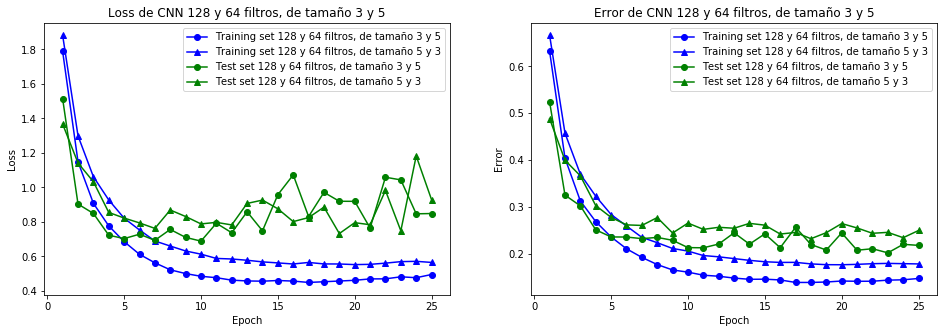

In [62]:
plot2(model_2c_128_64_3_5_rmsprop.history, "128 y 64 filtros, de tamaño 3 y 5", model_2c_128_64_5_3_rmsprop.history, "128 y 64 filtros, de tamaño 5 y 3")

h) Algunos investigadores, han propuesto que las capas de pooling se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [65]:
model_stride_2 = Sequential()
model_stride_2.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_stride_2.add(Activation('relu'))
model_stride_2.add(Conv2D(128, (3, 3), padding='same'))
model_stride_2.add(Activation('relu'))
model_stride_2.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same')) #si no funciona padding='valid'

model_stride_2.add(Dropout(0.25))

model_stride_2.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_stride_2.add(Activation('relu'))
model_stride_2.add(Conv2D( 64, (3, 3), padding='same'))
model_stride_2.add(Activation('relu'))
model_stride_2.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))

model_stride_2.add(Dropout(0.25))

model_stride_2.add(Flatten())
model_stride_2.add(Dense(512))
model_stride_2.add(Activation('relu'))
model_stride_2.add(Dropout(0.25))
model_stride_2.add(Dense(10,))
model_stride_2.add(Activation('softmax'))
model_stride_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 64)        36928     
__________

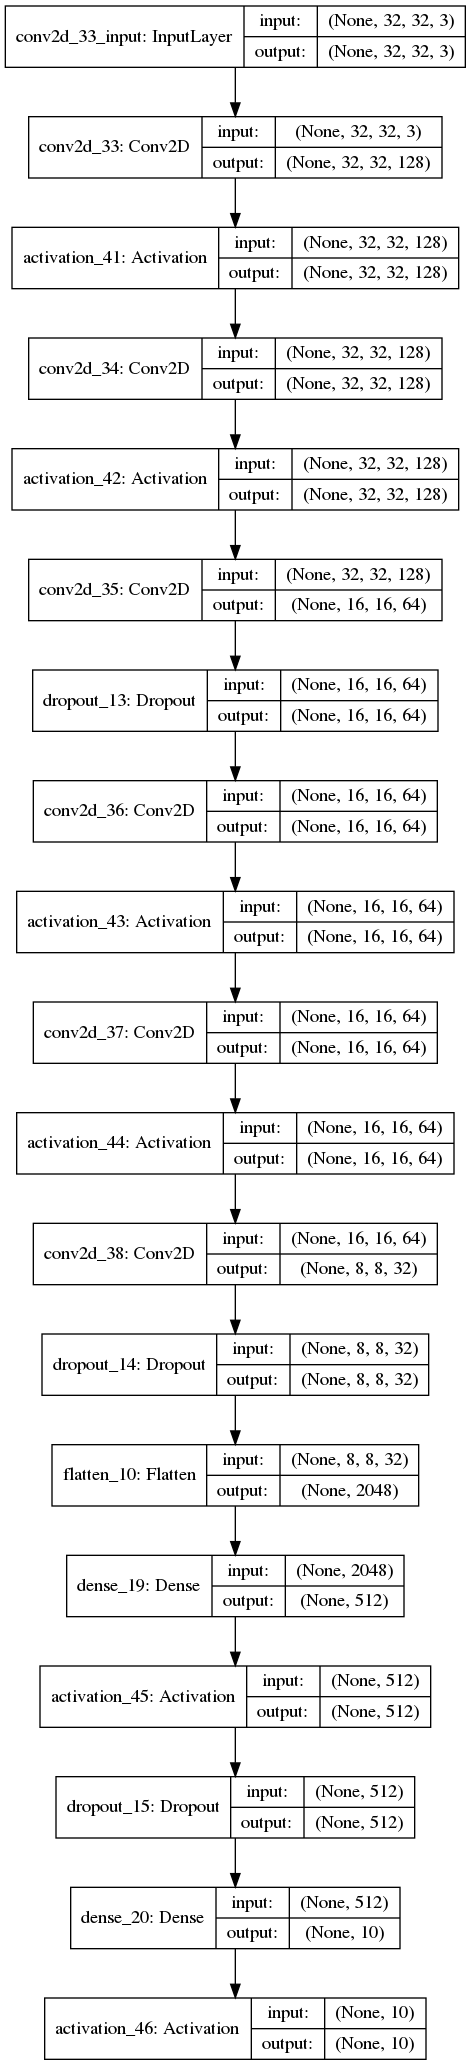

In [67]:
plot_model(model_stride_2, to_file='model_stride_2.png', show_shapes=True)
Image(filename='model_stride_2.png')

In [68]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_stride_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_stride_2_rmsprop = model_stride_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_stride_2.save('model_stride_2.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 225s 5ms/step - loss: 1.8548 - acc: 0.3282 - val_loss: 1.3753 - val_acc: 0.5060
Epoch 2/25
45000/45000 [==============================] - 227s 5ms/step - loss: 1.2712 - acc: 0.5504 - val_loss: 1.0524 - val_acc: 0.6370
Epoch 3/25
45000/45000 [==============================] - 227s 5ms/step - loss: 1.0089 - acc: 0.6460 - val_loss: 0.8387 - val_acc: 0.7032
Epoch 4/25
45000/45000 [==============================] - 233s 5ms/step - loss: 0.8627 - acc: 0.7011 - val_loss: 0.8151 - val_acc: 0.7096
Epoch 5/25
45000/45000 [==============================] - 227s 5ms/step - loss: 0.7473 - acc: 0.7401 - val_loss: 0.7584 - val_acc: 0.7292
Epoch 6/25
45000/45000 [==============================] - 223s 5ms/step - loss: 0.6541 - acc: 0.7727 - val_loss: 0.7694 - val_acc: 0.7394
Epoch 7/25
45000/45000 [==============================] - 224s 5ms/step - loss: 0.5873 - acc: 0.7980 - val_loss: 0.6877 - v

In [78]:
score_model_stride_2_rmsprop = model_stride_2.evaluate(x_test, y_test)
print("Cross entropy:", score_model_stride_2_rmsprop[0])
print("Accuracy: ", score_model_stride_2_rmsprop[1])

10000/10000 [==============================] - 18s 2ms/step
Cross entropy: 0.9497094947814941
Accuracy:  0.765


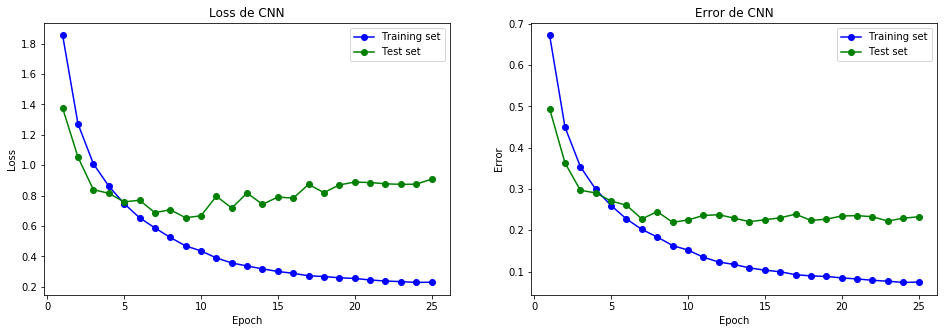

In [79]:
plot(model_stride_2_rmsprop.history)

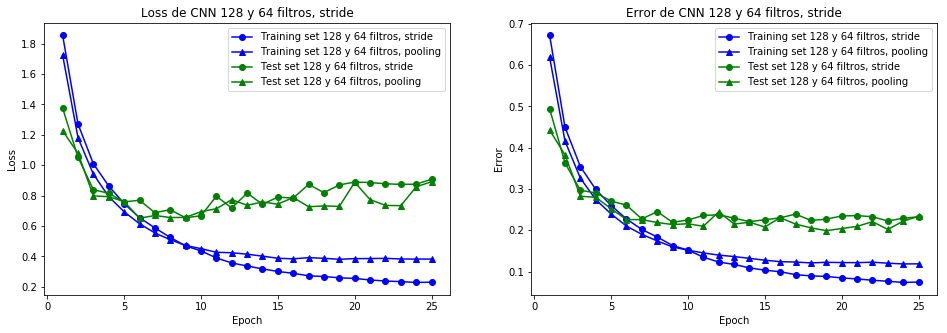

In [80]:
plot2(model_stride_2_rmsprop.history, "128 y 64 filtros, stride", model_2c_128_64_rmsprop.history, "128 y 64 filtros, pooling")

i) Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porqué este procedimiento podrı́a ayudar a mejorar el modelo y el porqué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

Se le aplican transformaciones a los ejemplos de entrenamiento y se vuelve a entrenar con la red de h

In [82]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
model_stride_2_regularizado = model_stride_2.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                                           steps_per_epoch=x_train.shape[0]// batch_size, 
                                                           epochs=epochs,validation_data=(x_val, y_val))

Epoch 1/25
450/450 [==============================] - 221s 490ms/step - loss: 0.8926 - acc: 0.7028 - val_loss: 0.3863 - val_acc: 0.8906
Epoch 2/25
450/450 [==============================] - 223s 495ms/step - loss: 0.8111 - acc: 0.7261 - val_loss: 0.4142 - val_acc: 0.8636
Epoch 3/25
450/450 [==============================] - 223s 496ms/step - loss: 0.7809 - acc: 0.7389 - val_loss: 0.4835 - val_acc: 0.8438
Epoch 4/25
450/450 [==============================] - 227s 504ms/step - loss: 0.7476 - acc: 0.7478 - val_loss: 0.5030 - val_acc: 0.8338
Epoch 5/25
450/450 [==============================] - 234s 520ms/step - loss: 0.7355 - acc: 0.7522 - val_loss: 0.4662 - val_acc: 0.8462
Epoch 6/25
450/450 [==============================] - 227s 505ms/step - loss: 0.7238 - acc: 0.7552 - val_loss: 0.4245 - val_acc: 0.8570
Epoch 7/25
450/450 [==============================] - 216s 480ms/step - loss: 0.7149 - acc: 0.7581 - val_loss: 0.5449 - val_acc: 0.8262
Epoch 8/25
450/450 [============================

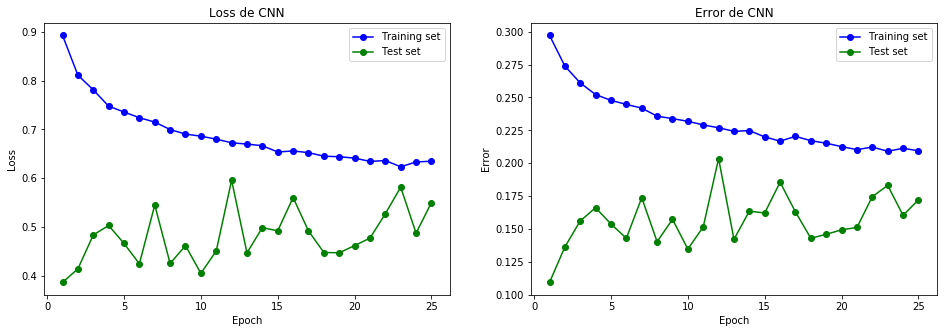

In [83]:
plot(model_stride_2_regularizado.history)

In [85]:
score_model_stride_2_regularizado = model_stride_2.evaluate(x_test, y_test)
print("Cross entropy:", score_model_stride_2_regularizado[0])
print("Accuracy: ", score_model_stride_2_regularizado[1])

10000/10000 [==============================] - 18s 2ms/step
Cross entropy: 0.6121658530235291
Accuracy:  0.8073


j) Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

Tomando la red entrenada anteriormente'

In [86]:
y_pred = model_stride_2.predict_classes(x_test) 
y_real = y_test.argmax(axis=1)

print("Clases predecidas ", y_pred)
print("Clases reales", y_real)

Clases predecidas  [3 8 8 ... 5 1 7]
Clases reales [3 8 8 ... 5 1 7]


In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_real, y_pred, target_names=label_names))
confusion = confusion_matrix(y_real, y_pred)

             precision    recall  f1-score   support

   airplane       0.88      0.76      0.81      1000
 automobile       0.94      0.90      0.92      1000
       bird       0.76      0.68      0.72      1000
        cat       0.67      0.65      0.66      1000
       deer       0.76      0.82      0.79      1000
        dog       0.76      0.71      0.73      1000
       frog       0.70      0.92      0.79      1000
      horse       0.86      0.85      0.86      1000
       ship       0.94      0.87      0.90      1000
      truck       0.86      0.91      0.89      1000

avg / total       0.81      0.81      0.81     10000



In [88]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #print(cm)
    plt.figure(figsize=(16,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

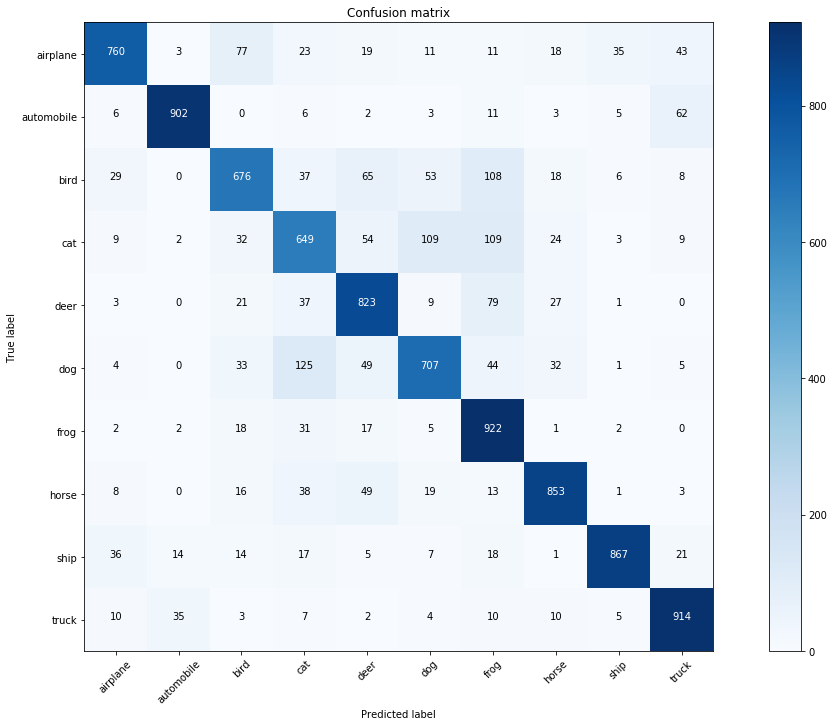

In [89]:
plot_confusion_matrix(confusion, classes=label_names, title='Confusion matrix')

In [90]:
def plot_gallery(images, titles, h=32, w=32, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
            
        plt.imshow(images[i].reshape(3,32,32).transpose([1, 2, 0]), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

index_dif = np.where(y_pred != y_real)

(array([   3,   15,   17, ..., 9993, 9995, 9996]),)


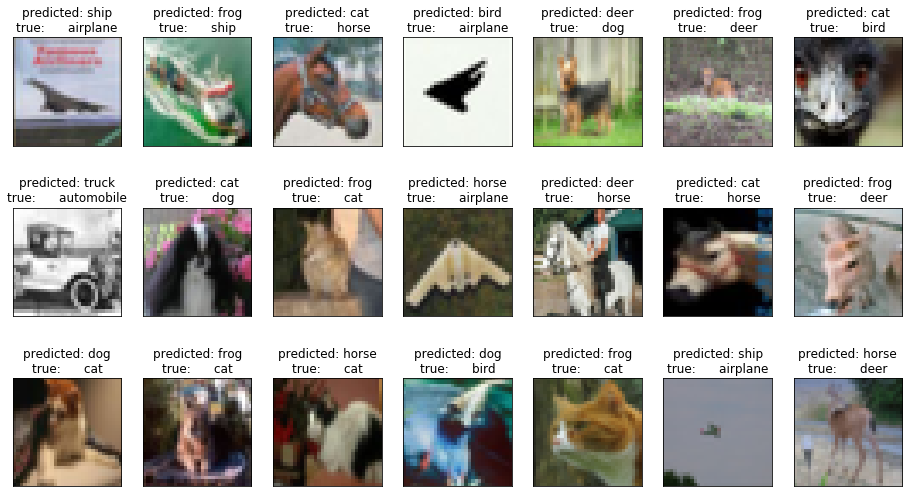

In [91]:
print(index_dif)

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_real, label_names, i)for i in index_dif[0]]
#print(len(prediction_titles))

plot_gallery([X[i] for i in index_dif][0], prediction_titles, n_row=3, n_col=7)

plt.show()

In [92]:
def imagen_y_rgb(imagen, label, n):
    rgb = imagen[n].reshape(3,1024)
    canal_r = rgb[0].reshape(32,32)
    canal_g = rgb[1].reshape(32,32)
    canal_b = rgb[2].reshape(32,32)
    
    fig = plt.figure(figsize=(8,3))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Label: "+ label_names[label[n]])
    true_imagen = imagen[n].reshape(3,32,32)
    true_imagen = true_imagen.transpose([1, 2, 0])
    ax.imshow(true_imagen)
    ax.set_yticks([])
    ax.set_xticks([])

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(canal_r, interpolation="bicubic")
    ax.imshow(canal_g, interpolation="bicubic")
    ax.imshow(canal_b, interpolation="bicubic")
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()

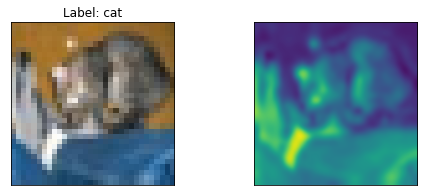

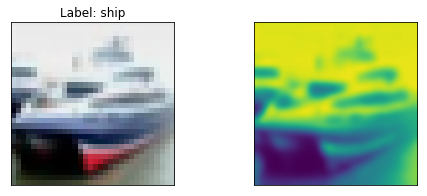

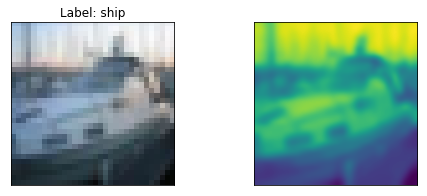

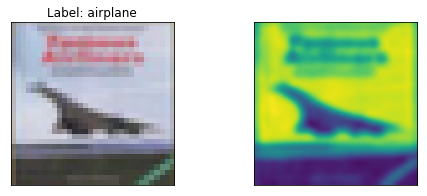

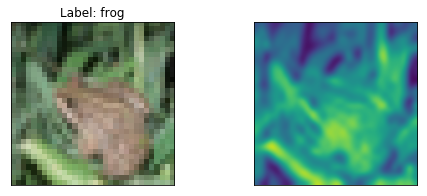

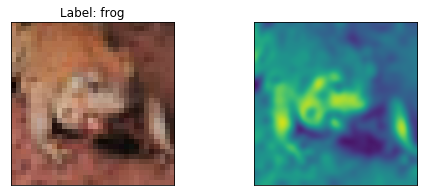

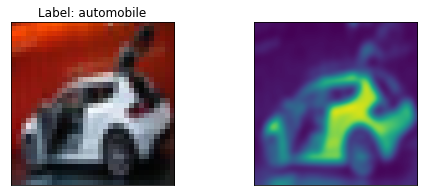

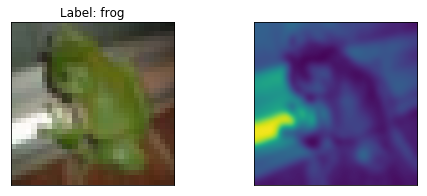

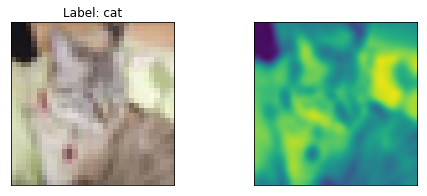

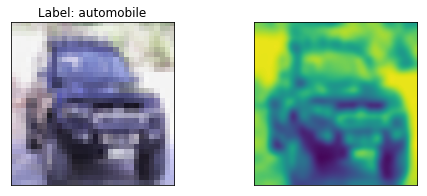

In [93]:
for i in range(10):
    imagen_y_rgb(X,Y,i)

k) Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional. Comente.

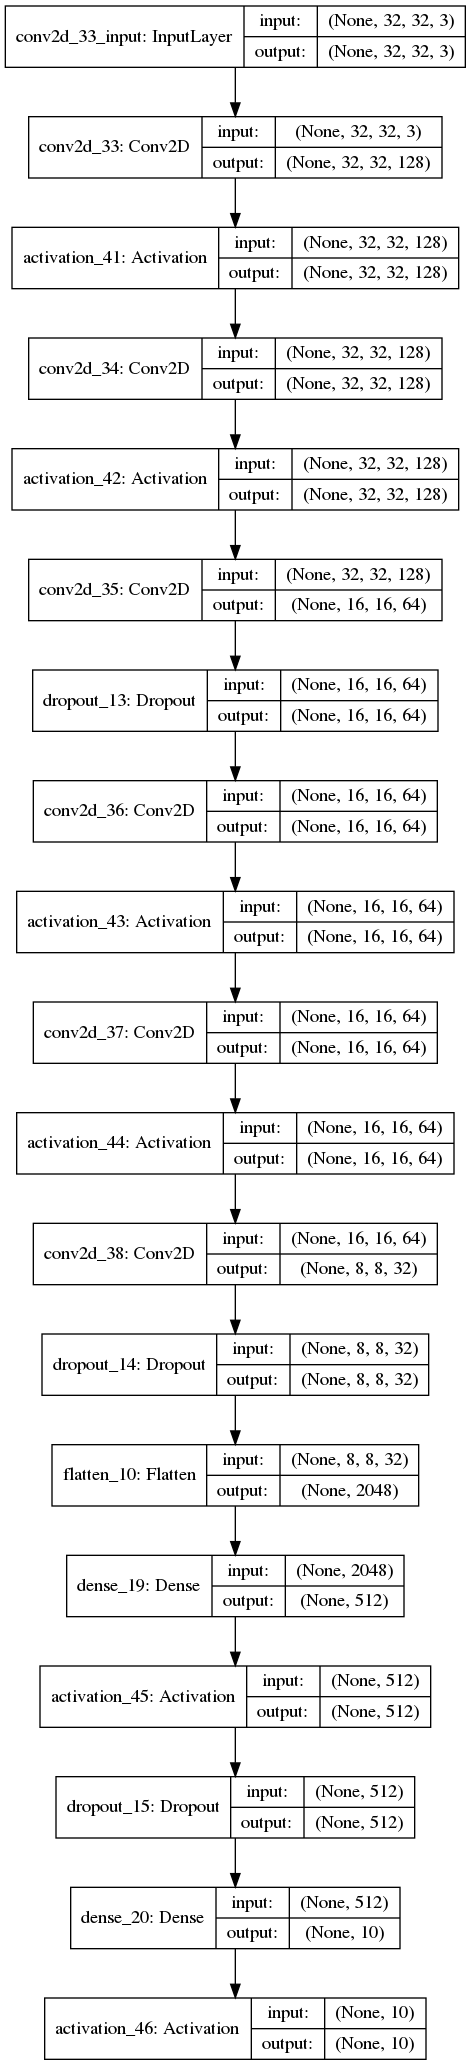

In [94]:
plot_model(model_stride_2, to_file='model_2c_128_64_weights.png', show_shapes=True)
Image(filename='model_2c_128_64_weights.png')

In [95]:
weights_primera = model_2c_128_64.layers[0].get_weights() #cambiar modelo
weights_ultima = model_2c_128_64.layers[8].get_weights() #cambiar modelo
print("primera capa convolucional: ")
print(weights_primera[0].shape)
print(weights_primera[0][:,:,:,0])

print("ultima capa convolucional: ")
print(weights_ultima[0].shape)
print(weights_ultima[0][:,:,:,0])

primera capa convolucional: 
(3, 3, 3, 128)
[[[ 0.0228436   0.01394945  0.00042698]
  [-0.09301263  0.00221094  0.04915403]
  [-0.09416688 -0.00449094 -0.02662166]]

 [[-0.05431469  0.03397406 -0.03206902]
  [-0.10510551 -0.03553367  0.0222965 ]
  [-0.00772341  0.07539637  0.11138795]]

 [[-0.14185324 -0.17287126 -0.20708883]
  [ 0.0153887   0.02479766 -0.01223897]
  [-0.09024229 -0.0569394  -0.08363534]]]
ultima capa convolucional: 
(3, 3, 64, 64)
[[[ 0.03328485  0.13578214  0.1424547  -0.00668579  0.06828391
   -0.00553795 -0.13075106 -0.02475457 -0.03895761  0.18831332
    0.01801144  0.18654732  0.14839105  0.23400106  0.17327766
   -0.0881658   0.15030307 -0.05759671 -0.10605016 -0.03709589
   -0.05520028 -0.07252376  0.20150211  0.00198828  0.0271658
   -0.02049543  0.06092362  0.03932833  0.06306909  0.07755423
    0.10206223 -0.0548982   0.06601879 -0.17170183 -0.1833989
    0.00481026 -0.19227959 -0.10214178  0.18454409 -0.06170962
    0.12464083 -0.10672671  0.15048414 -0.068

In [96]:
def plot_weights(imagen, title, n=8):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imagen[:,:,i],cmap='gray')
        plt.title(str(i+1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imagen[:,:,n+i],cmap='gray')
        plt.suptitle(title)
        plt.title(str(i+n+1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

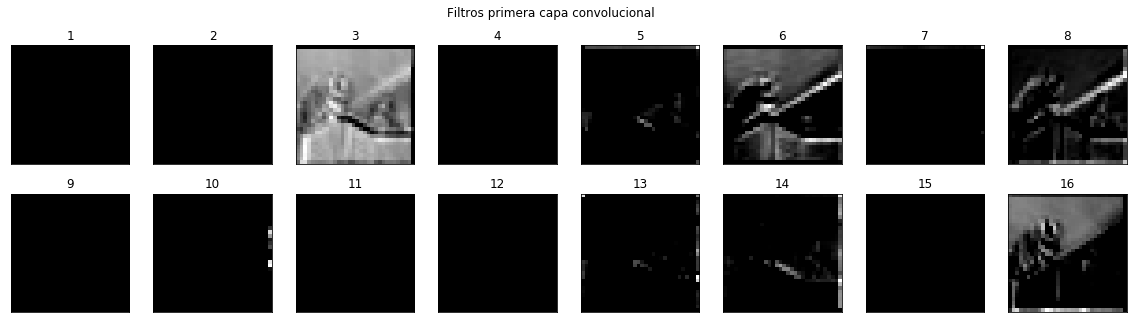

In [97]:
from keras.models import Model
from keras.layers import Input

intermediate_layer_model = Model(inputs=model_2c_128_64.input,
                                 outputs=model_2c_128_64.layers[1].output)
intermediate_output = intermediate_layer_model.predict(x_train[:100])
#print(intermediate_output.shape[1:])

im_lay_1 = intermediate_output[2]

plot_weights(im_lay_1, "Filtros primera capa convolucional")


intermediate_layer_model = Model(inputs=model_2c_128_64.input,
                                 outputs=model_2c_128_64.layers[2].output)
intermediate_output = intermediate_layer_model.predict(x_train[:100])

(32, 32, 128)


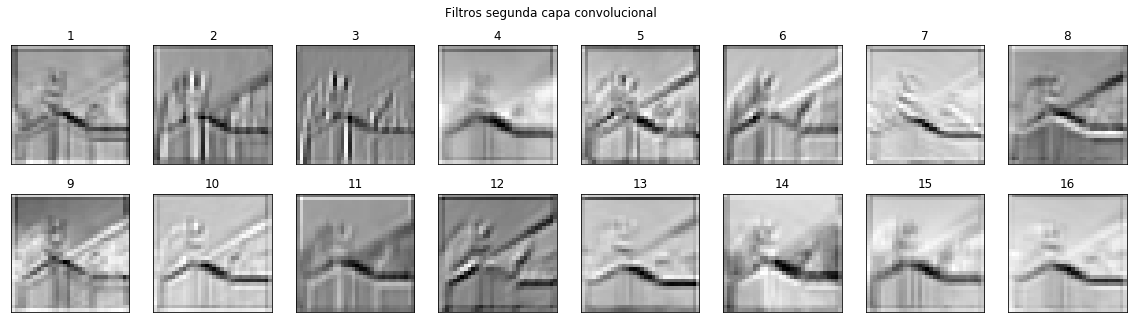

In [98]:
print(intermediate_output.shape[1:])

im_lay_2 = intermediate_output[2]

plot_weights(im_lay_2, "Filtros segunda capa convolucional")



intermediate_layer_model = Model(inputs=model_2c_128_64.input,
                                 outputs=model_2c_128_64.layers[6].output)
intermediate_output = intermediate_layer_model.predict(x_train[:100])

(16, 16, 64)


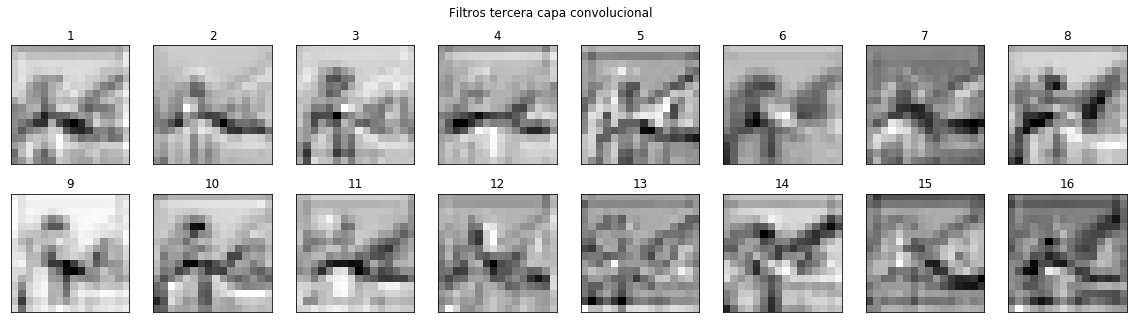

In [99]:
print(intermediate_output.shape[1:])

im_lay_6 = intermediate_output[2]

plot_weights(im_lay_6, "Filtros tercera capa convolucional")


intermediate_layer_model = Model(inputs=model_2c_128_64.input,
                                 outputs=model_2c_128_64.layers[8].output)
intermediate_output = intermediate_layer_model.predict(x_train[:100])

(16, 16, 64)


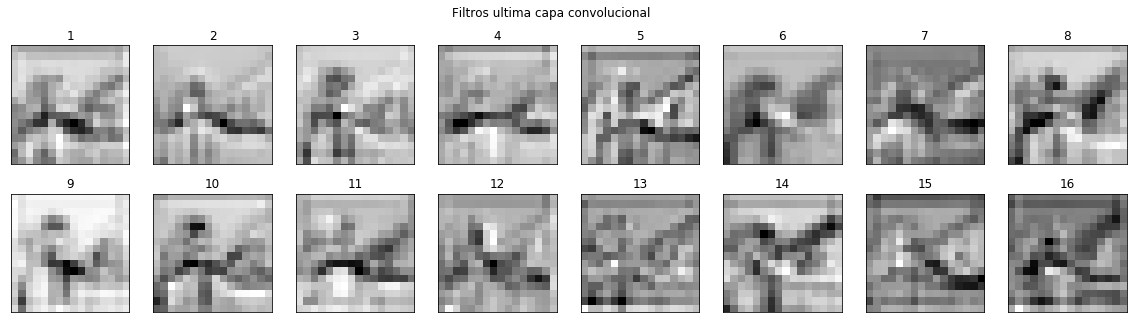

In [100]:
print(intermediate_output.shape[1:])

im_lay_8 = intermediate_output[2]

plot_weights(im_lay_6, "Filtros ultima capa convolucional")